# **D214 MSDA Capstone:** Task 2  

**Student:** Chris Fischer  
**ID:** 011933891  

### *Research Question*  

To what extent can the features of a proposed residential solar project (system size, single/multi-phase, self-installed, number of modules, module capacity, module efficiency, and battery capacity) affect its total installed cost?

## Initialization
---

In [1]:
# Import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2, mean_absolute_error as MAE

# Set some Pandas options
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format

# Define some helpful lists
target_var=['price_per_watt']
boolean_vars=['multiple_phase_system','self_installed']
numerical_vars=['PV_system_size_DC','module_quantity_1','nameplate_capacity_module_1','efficiency_module_1','battery_rated_capacity_kW']
all_vars = ['total_installed_price'] + boolean_vars + numerical_vars

In [2]:
df = pd.read_csv('TTS_LBNL_public_file_21-Aug-2024_SanDiego_RES_2023_Anonymized.csv', keep_default_na=True, usecols=all_vars, na_values=['-1'])
df['price_per_watt'] = df['total_installed_price'] / df['PV_system_size_DC'] / 1000
df.info()
df.describe()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43625 entries, 0 to 43624
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PV_system_size_DC            42795 non-null  float64
 1   total_installed_price        43557 non-null  float64
 2   multiple_phase_system        43620 non-null  float64
 3   self_installed               43625 non-null  int64  
 4   module_quantity_1            42795 non-null  float64
 5   nameplate_capacity_module_1  42790 non-null  float64
 6   efficiency_module_1          42790 non-null  float64
 7   battery_rated_capacity_kW    5850 non-null   float64
 8   price_per_watt               42738 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 3.0 MB


,PV_system_size_DC,total_installed_price,multiple_phase_system,self_installed,module_quantity_1,nameplate_capacity_module_1,efficiency_module_1,battery_rated_capacity_kW,price_per_watt
0,28.75,99000.00,0.00,0,71.00,405.00,0.21,NaN,3.44
1,7.80,61808.00,1.00,0,20.00,390.00,0.20,NaN,7.92
2,4.00,18181.00,0.00,0,10.00,400.00,0.20,NaN,4.55
3,8.40,34752.00,0.00,0,21.00,400.00,0.21,NaN,4.14
4,3.50,16000.00,0.00,0,10.00,350.00,0.20,NaN,4.57
5,26.65,118250.00,0.00,0,65.00,410.00,0.23,20.00,4.44
6,10.53,54888.00,0.00,0,26.00,405.00,0.21,3.84,5.21
7,4.20,11970.00,0.00,0,12.00,350.00,0.20,NaN,2.85
8,NaN,78257.00,0.00,0,NaN,NaN,NaN,7.68,NaN
9,NaN,28600.00,1.00,0,NaN,NaN,NaN,10.00,NaN


## Cleaning
---

In [3]:
# Calculate sparsity
sparsity = df.isna().sum().sum()/ df.size
print(f'Sparsity: {sparsity:.2%}')

Sparsity: 10.71%


In [4]:
# Check for missing
df.isnull().sum()

PV_system_size_DC                830
total_installed_price             68
multiple_phase_system              5
self_installed                     0
module_quantity_1                830
nameplate_capacity_module_1      835
efficiency_module_1              835
battery_rated_capacity_kW      37775
price_per_watt                   887
dtype: int64

In [5]:
# Replace Nan with 0.0 in battery_rated_capacity_kW
df['battery_rated_capacity_kW'] = df['battery_rated_capacity_kW'].fillna(0)

In [6]:
# Drop observations with any remaining NA columns
df = df.dropna().reset_index(drop=True)
df.describe()

,PV_system_size_DC,total_installed_price,multiple_phase_system,self_installed,module_quantity_1,nameplate_capacity_module_1,efficiency_module_1,battery_rated_capacity_kW,price_per_watt
count,42729.00,42729.00,42729.00,42729.00,42729.00,42729.00,42729.00,42729.00,42729.00
mean,6.52,28726.14,0.14,0.03,16.57,395.46,0.21,0.73,4.51
std,5.09,23402.68,0.35,0.17,13.23,26.21,0.01,2.25,2.25
min,0.36,1.00,0.00,0.00,1.00,46.00,0.07,0.00,0.00
25%,4.15,16678.00,0.00,0.00,11.00,395.00,0.21,0.00,3.40
50%,5.60,24225.00,0.00,0.00,14.00,400.00,0.21,0.00,4.20
75%,8.00,35065.00,0.00,0.00,20.00,400.00,0.21,0.00,5.21
max,342.95,1535037.00,1.00,1.00,943.00,550.00,0.24,40.96,44.44


In [7]:
# Cast several features as ints
df['multiple_phase_system'] = df['multiple_phase_system'].astype(np.int64)
df['module_quantity_1'] = df['module_quantity_1'].astype(np.int64)
df['nameplate_capacity_module_1'] = df['nameplate_capacity_module_1'].astype(np.int64)
df['total_installed_price'] = df['total_installed_price'].astype(np.int64)

In [8]:
# Detect potential outliers
df_z = (df[numerical_vars] - df[numerical_vars].mean())/df[numerical_vars].std(ddof=0)
outlier_cols = df_z.loc[: , (df_z > 3.0).any()].columns
for col in outlier_cols :
    cnt = len(df_z[df_z[col]>3])
    min, max = df[col].min(), df[col].max()
    print(f'Likely outlier for {col:<30}\t Count: {cnt:7d} ({cnt/len(df_z):5.2%} of observations)\tMin: {min:>9.2f}\tMax: {max:>9.2f}')

Likely outlier for PV_system_size_DC             	 Count:     240 (0.56% of observations)	Min:      0.36	Max:    342.95
Likely outlier for module_quantity_1             	 Count:     249 (0.58% of observations)	Min:      1.00	Max:    943.00
Likely outlier for nameplate_capacity_module_1   	 Count:     931 (2.18% of observations)	Min:     46.00	Max:    550.00
Likely outlier for efficiency_module_1           	 Count:       6 (0.01% of observations)	Min:      0.07	Max:      0.24
Likely outlier for battery_rated_capacity_kW     	 Count:    1148 (2.69% of observations)	Min:      0.00	Max:     40.96


In [9]:
# Don't count any outliers in battery_rated_capacity_kW
df_z['battery_rated_capacity_kW'] = 0.0

In [10]:
# Get rid of rows with z score > 3.0
mask = (df_z.abs() <= 3).all(axis=1)
df = df[mask].reset_index(drop=True)
df.describe()

,PV_system_size_DC,total_installed_price,multiple_phase_system,self_installed,module_quantity_1,nameplate_capacity_module_1,efficiency_module_1,battery_rated_capacity_kW,price_per_watt
count,41336.00,41336.00,41336.00,41336.00,41336.00,41336.00,41336.00,41336.00,41336.00
mean,6.29,28145.66,0.14,0.02,15.96,394.09,0.21,0.72,4.55
std,2.91,18544.72,0.35,0.15,7.32,19.89,0.01,2.19,2.23
min,0.36,1.00,0.00,0.00,1.00,320.00,0.19,0.00,0.00
25%,4.05,16741.50,0.00,0.00,10.00,395.00,0.21,0.00,3.44
50%,5.60,24234.50,0.00,0.00,14.00,400.00,0.21,0.00,4.22
75%,7.81,34937.50,0.00,0.00,20.00,400.00,0.21,0.00,5.23
max,21.75,550004.00,1.00,1.00,56.00,470.00,0.23,40.96,43.09


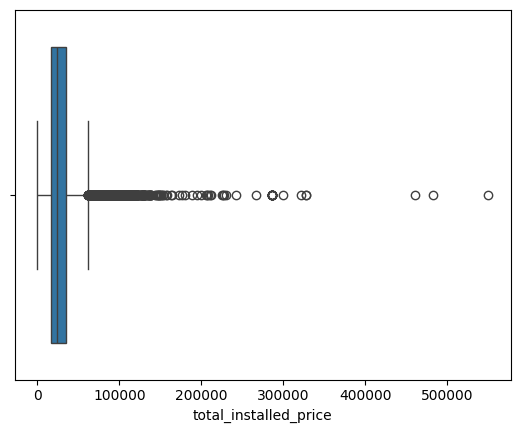

In [11]:
# Explore total_installed_price further
sns.boxplot(data=df, x='total_installed_price')
plt.show()

In [12]:
# Calculate the IQR
Q1 = df['total_installed_price'].quantile(0.25)
Q3 = df['total_installed_price'].quantile(0.75)
IQR = Q3 - Q1
LOWER = Q1 - (1.5 * IQR)
UPPER = Q3 + (1.5 * IQR)
print(f"Q1 of 'total_installed_price'   : {Q1}")
print(f"Q3 of 'total_installed_price'   : {Q3}")
print(f"IQR of 'total_installed_price'  : {IQR}")
print(f"LOWER of 'total_installed_price': {LOWER}")
print(f"UPPER of 'total_installed_price': {UPPER}")


Q1 of 'total_installed_price'   : 16741.5
Q3 of 'total_installed_price'   : 34937.5
IQR of 'total_installed_price'  : 18196.0
LOWER of 'total_installed_price': -10552.5
UPPER of 'total_installed_price': 62231.5


In [13]:
# Remove observations with total_installed_price < 1000 or > 100000
print(f'Projects <   1,000: {(df['total_installed_price'] < 1000).sum()}')
print(f'Projects > 100,000: {(df['total_installed_price'] > 100000).sum()}')

df.drop(df[(df['total_installed_price'] < 1000) | (df['total_installed_price'] > 100000)].index, inplace=True)
df.describe()

Projects <   1,000: 292
Projects > 100,000: 230


,PV_system_size_DC,total_installed_price,multiple_phase_system,self_installed,module_quantity_1,nameplate_capacity_module_1,efficiency_module_1,battery_rated_capacity_kW,price_per_watt
count,40814.00,40814.00,40814.00,40814.00,40814.00,40814.00,40814.00,40814.00,40814.00
mean,6.27,27698.81,0.14,0.02,15.91,394.06,0.21,0.71,4.53
std,2.85,15619.61,0.35,0.15,7.17,19.90,0.01,2.14,2.04
min,0.36,1000.00,0.00,0.00,1.00,320.00,0.19,0.00,0.07
25%,4.10,16830.00,0.00,0.00,11.00,395.00,0.21,0.00,3.45
50%,5.60,24264.00,0.00,0.00,14.00,400.00,0.21,0.00,4.23
75%,7.79,34771.75,0.00,0.00,20.00,400.00,0.21,0.00,5.22
max,21.75,100000.00,1.00,1.00,55.00,470.00,0.23,38.70,43.05


## EDA
---

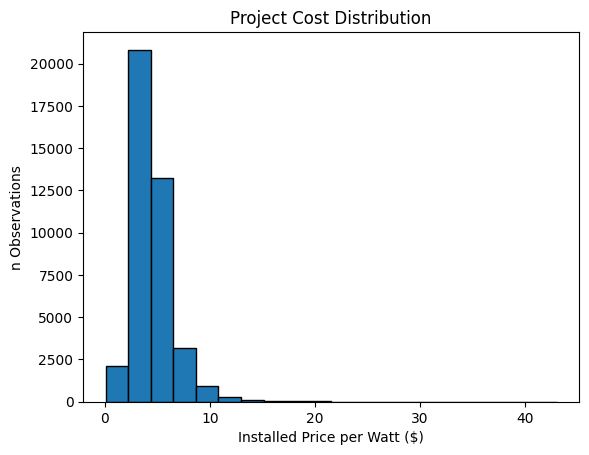

In [14]:
# Dependent variable
df.hist(target_var, grid=False, bins=20, edgecolor='black')
plt.xlabel('Installed Price per Watt ($)')
plt.ylabel('n Observations')
plt.title('Project Cost Distribution')
plt.show()

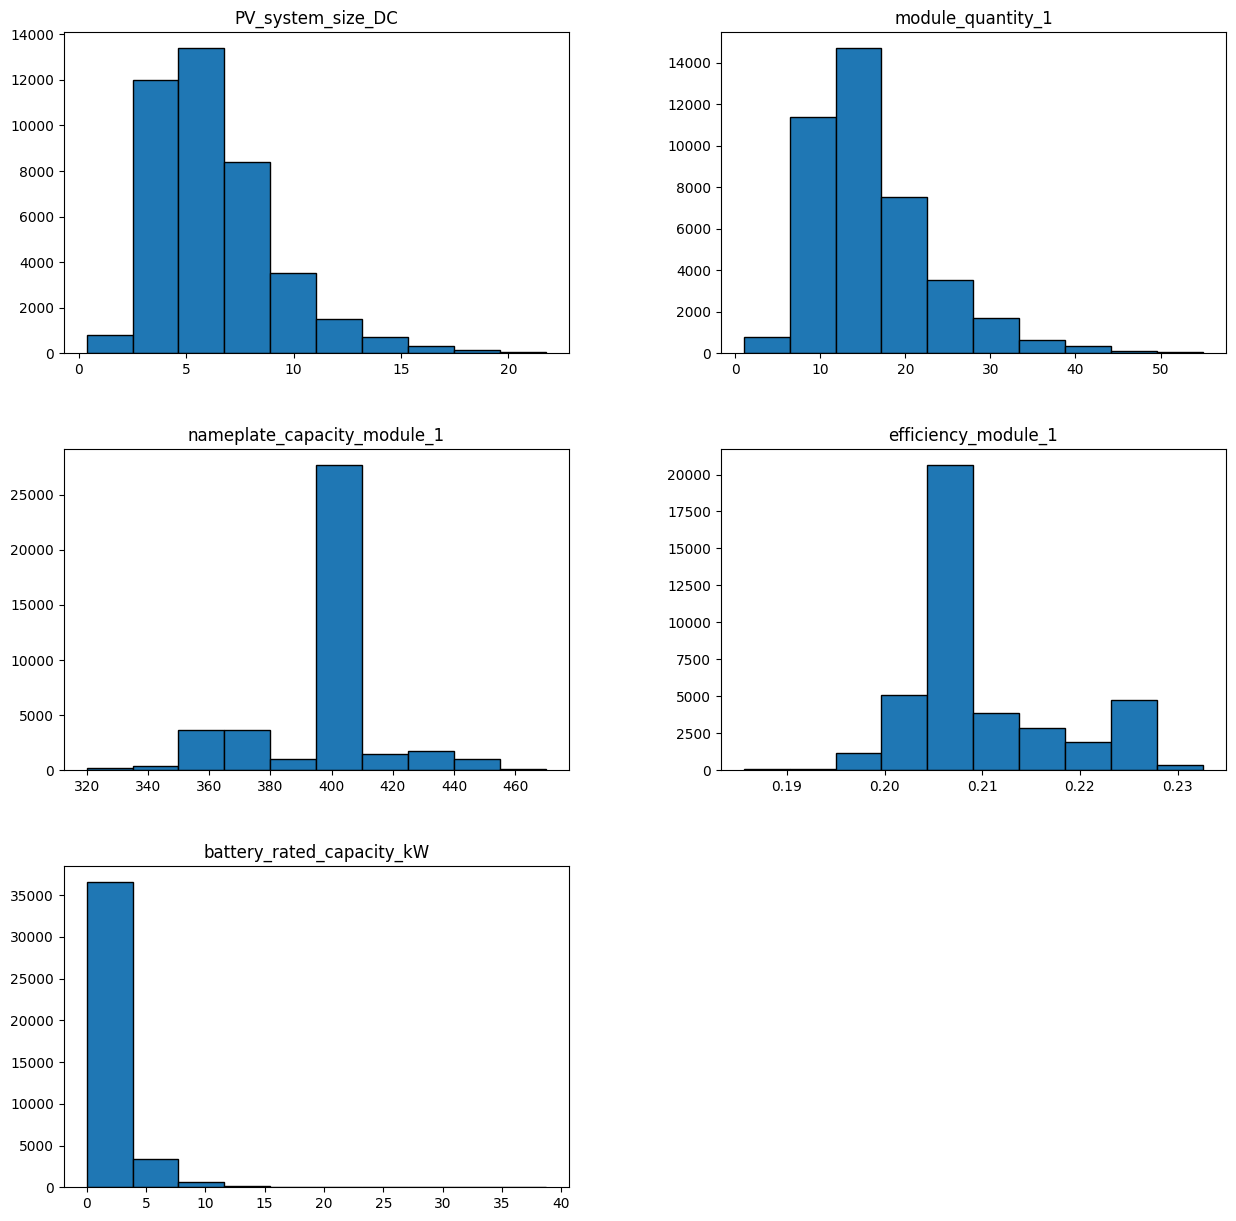

In [15]:
# Independent numeric variables univariate
df.hist(numerical_vars, grid=False, edgecolor='black', figsize=(15,15))
plt.show()

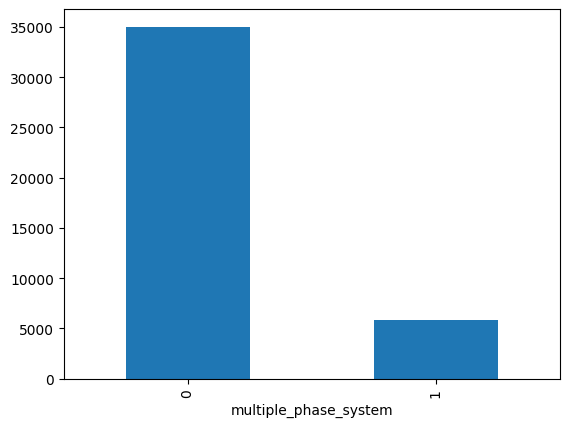

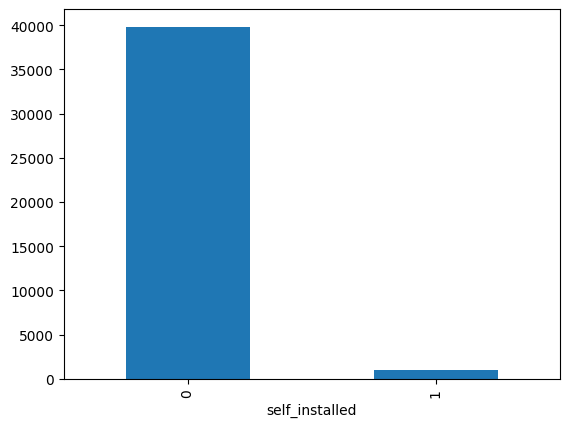

In [16]:
# Independent categorical variables univariate
for col in boolean_vars :
    df[col].value_counts().sort_index().plot(kind='bar')
    plt.show()

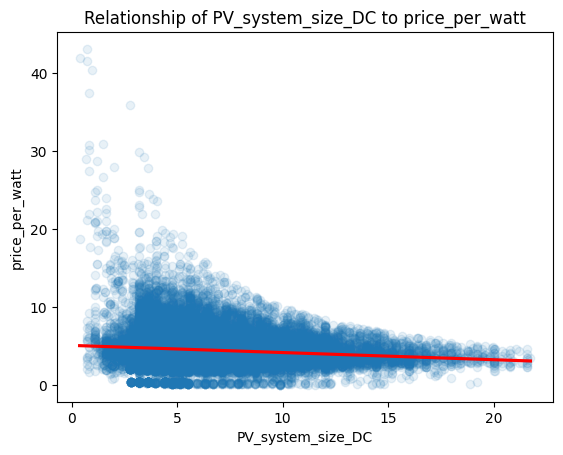

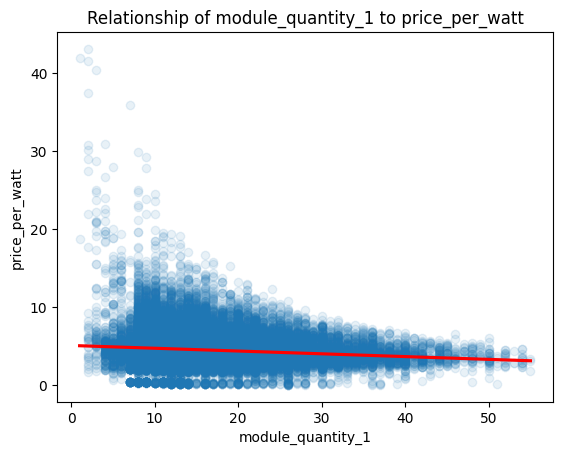

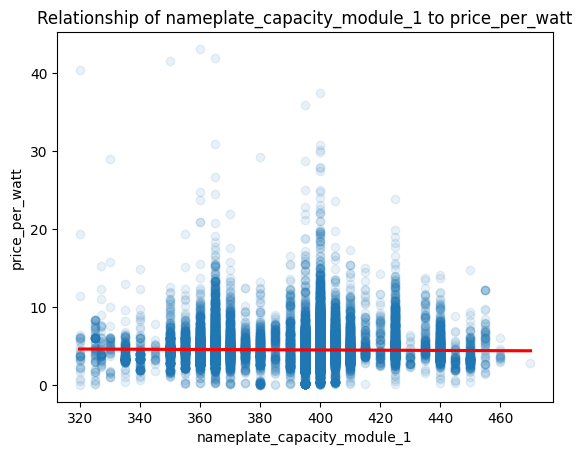

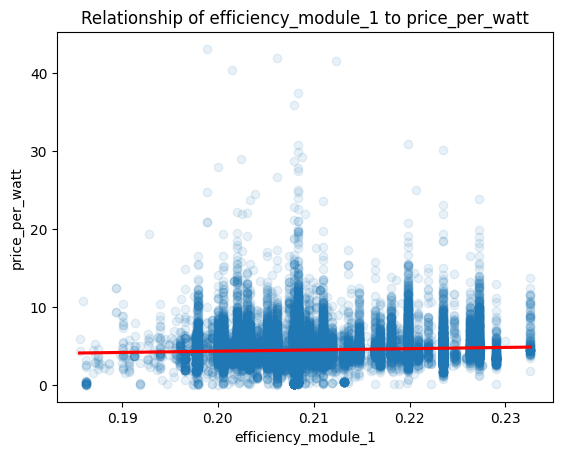

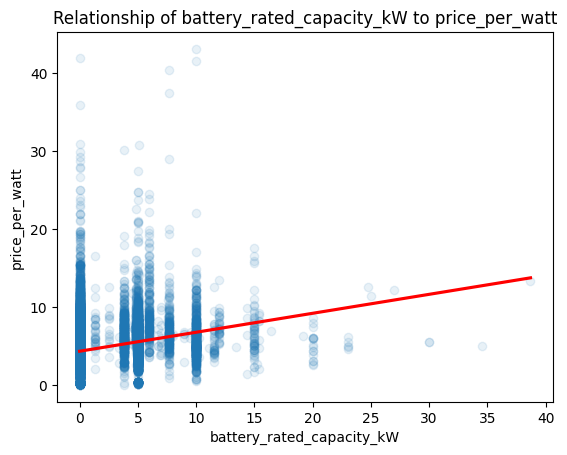

In [17]:
# Bivariate numerical
for col in numerical_vars :
    sns.regplot(data=df, x=col, y=target_var[0], scatter_kws={'alpha' : 1/10}, line_kws = {'color': 'red'}, ci=None)
    plt.title(f'Relationship of {col} to {target_var[0]}')
    plt.show()

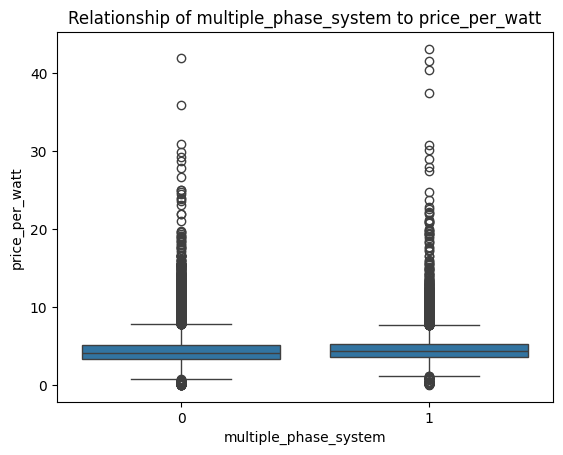

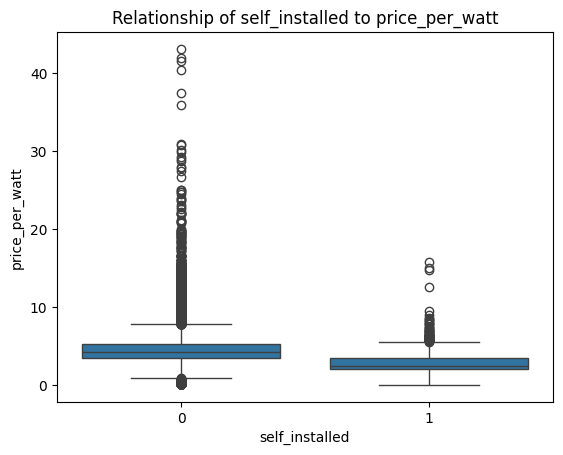

In [18]:
# Bivariate categorical
for col in boolean_vars :
    sns.boxplot(data=df, x=col, y=target_var[0])
    plt.title(f'Relationship of {col} to {target_var[0]}')
    plt.show()

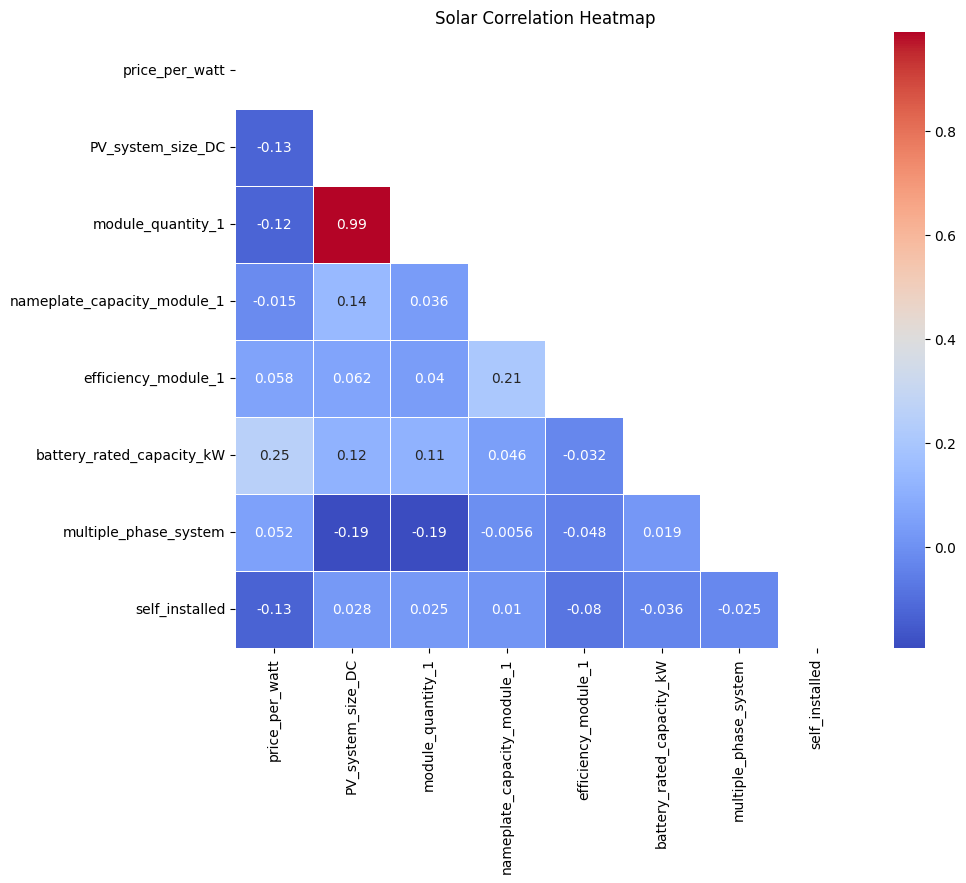

In [19]:
# Plot a correlation heatmap
corr = df[target_var+numerical_vars+boolean_vars].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Solar Correlation Heatmap')
plt.show()


## Modeling
---

In [20]:
# Check for feature colliniarity and drop high VIFs [In-Text Citation: (Prashant, 2016)]
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif(X, thresh=5.0):
    X = X.assign(const=1)
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]
        vif = vif[:-1]  # always preserve the constant
        maxvif = np.max(vif)
        maxloc = vif.index(maxvif)
        if maxvif > thresh:
            print(f'dropping {X.iloc[:, variables].columns[maxloc]:30} at index: {str(maxloc)} with VIF: {maxvif:.5f}')
            del variables[maxloc]
            dropped = True

    return X.iloc[:, variables[:-1]], X.columns[variables[:-1]]

X_full = numerical_vars + boolean_vars
y = target_var

tmp_df, X_full = calculate_vif(df[X_full],5.0)
# Merge post VIF reduction df with the target variable from the df

df = pd.concat([tmp_df, df[y]], axis=1) 

dropping PV_system_size_DC              at index: 0 with VIF: 143.80531


In [21]:
# Iteratively remove features with p-values above an acceptable value (Vijayakumar, 2020)
def backward_elimination(X, y, threshold_out, verbose=False):
    included=list(X.columns)

    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature:30} with p-value {worst_pval:.5f}')
        if not changed:
            break

    return X[included], included

tmp_df, X_reduced = backward_elimination(df[X_full], df[target_var], 0.05, True)
df = pd.concat([tmp_df, df[target_var]], axis=1) # Merge post feature reduction df with the target variable from the df

In [22]:
# Normalize values prior to modeling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
df = pd.DataFrame(scaled_data, columns=df.columns)

In [23]:
# Construct OLS model with no interactions
formula='price_per_watt ~ '
first = True
for col in X_full :
    if first :
        first = False
    else :
        formula += ' + '
    formula += col

print(formula)
mdl_full = smf.ols(formula = formula, data = df).fit()
print(mdl_full.summary())

price_per_watt ~ module_quantity_1 + nameplate_capacity_module_1 + efficiency_module_1 + battery_rated_capacity_kW + multiple_phase_system + self_installed
                            OLS Regression Results                            
Dep. Variable:         price_per_watt   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     817.8
Date:                Sat, 07 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:12:01   Log-Likelihood:                -55595.
No. Observations:               40814   AIC:                         1.112e+05
Df Residuals:                   40807   BIC:                         1.113e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err     

MODEL FIT METRICS:
R2      = 0.10734
R2-adj  = 0.10721
MSE     = 0.89281
RSE     = 0.94489
x̄ resid = 0.00000


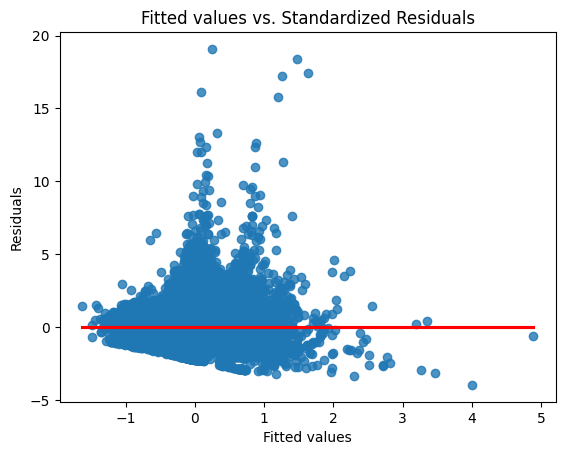

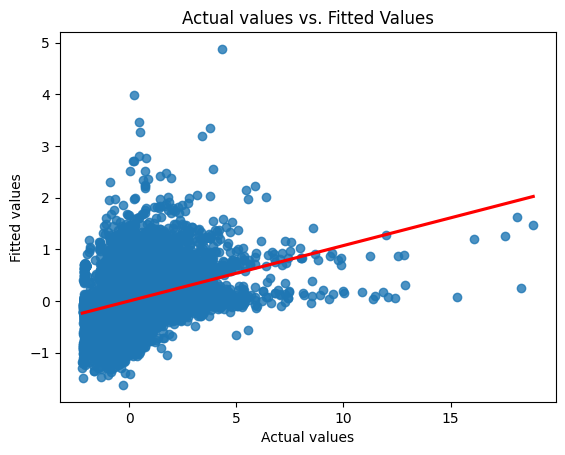

In [24]:
# Generate model statistics
def model_fit_statistics (model_name, model, actual_y) :
    model_results = {'model': model_name, 
                     'r2': model.rsquared, 
                     'r2-adj': model.rsquared_adj, 
                     'mse': model.mse_resid,
                     'rse': np.sqrt(model.mse_resid), 
                     'resid_mean': np.mean(model.resid)}

    print('MODEL FIT METRICS:')
    print(f'R2      = {model_results["r2"]:.5f}')
    print(f'R2-adj  = {model_results["r2-adj"]:.5f}')
    print(f'MSE     = {model_results["mse"]:.5f}')
    print(f'RSE     = {model_results["rse"]:.5f}')
    print(f'x̄ resid = {model_results["resid_mean"]:.5f}')

    std_resid = (model.resid-model.resid.mean())/model.resid.std()

    sns.regplot(x=model.fittedvalues, y=std_resid, data=None, ci=None, line_kws={"color": "red"})
    plt.title('Fitted values vs. Standardized Residuals')
    plt.xlabel ('Fitted values')
    plt.ylabel ('Residuals')
    plt.show()

    sns.regplot(x=actual_y, y=model.fittedvalues, data=None, ci=None, line_kws={"color": "red"})
    plt.title('Actual values vs. Fitted Values')
    plt.xlabel ('Actual values')
    plt.ylabel ('Fitted values')
    plt.show()

    return model_results

mdl_full_results = model_fit_statistics('Full', mdl_full, df[y])

In [25]:
# Perform Breusch-Pagan Test for heteroscedasticity (Bobbitt, 2020)
from statsmodels.stats.diagnostic import het_breuschpagan

def breusch_pagan(fitted_model):
    # Get the residuals and the design matrix (explanatory variables)
    residuals = fitted_model.resid
    exog = fitted_model.model.exog
    
    # Perform the Breusch-Pagan test
    test_stat, pvalue, _, _ = het_breuschpagan(residuals, exog)
    
    # Return the test result as a dictionary
    bp_test_result = {
        'Breusch-Pagan statistic': test_stat,
        'Breusch-Pagan pvalue': pvalue
    }
    
    return bp_test_result

print(breusch_pagan(mdl_full))

{'Breusch-Pagan statistic': 647.9337060355133, 'Breusch-Pagan pvalue': 1.0608052516030026e-136}


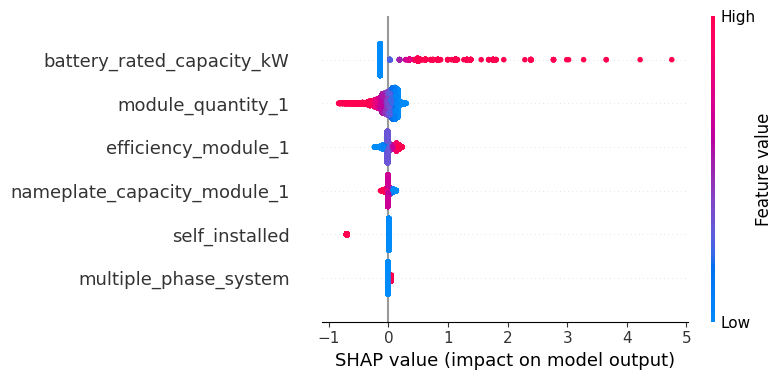

In [26]:
import shap
import sklearn
mdl_lin = sklearn.linear_model.LinearRegression().fit(df[X_full], df[y])

explainer = shap.explainers.Linear(mdl_lin, df[X_full])
shap_values = explainer(df[X_full])
shap.summary_plot(shap_values, df[X_full])